In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
from datasets import load_dataset
from torch.utils.data import DataLoader, Subset
import pandas as pd
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### PROVIDED CODE #####

def tokenize(
    text: "list[str]", max_length: int = None, normalize: bool = True
) -> "list[list[str]]":
    import re
    if normalize:
        regexp = re.compile("[^a-zA-Z ]+")
        # Lowercase, Remove non-alphanum
        text = [regexp.sub("", t.lower()) for t in text]
    return [t.split()[:max_length] for t in text]

def build_index_map(
    word_counts: "dict[str, int]", max_words: int = None
) -> "dict[str, int]":
    sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    if max_words:
        sorted_counts = sorted_counts[:max_words-1]
    sorted_words = ["[PAD]"] + [item[0] for item in sorted_counts]
    return {word: ix for ix, word in enumerate(sorted_words)}

def build_word_counts(dataloader) -> "dict[str, int]":
    word_counts = {}
    for batch in dataloader:
        for words in tokenize(batch['premise'] + batch['hypothesis']):
            for word in words:
                word_counts[word] = word_counts.get(word, 0) + 1
    return word_counts

def tokens_to_ix(
    tokens: "list[list[str]]", index_map: "dict[str, int]"
) -> "list[list[int]]":
    return [
        [index_map[word] for word in words if word in index_map] for words in tokens
    ]


In [7]:
def fix_padding(batch_premises, batch_hypotheses):
    bat_premises= []
    bat_hypotheses= []
    bat_premises_rev = []
    bat_hypotheses_rev = []
    for ex in batch_premises:
        bat_premises.append(torch.tensor(ex))
        bat_premises_rev.append(torch.tensor(ex[::-1]))
    for ex in batch_hypotheses:
        bat_hypotheses.append(torch.tensor(ex))
        bat_hypotheses_rev.append(torch.tensor(ex[::-1]))
    p= torch.nn.utils.rnn.pad_sequence(bat_premises, batch_first= True).type(torch.IntTensor).to(device)
    h= torch.nn.utils.rnn.pad_sequence(bat_hypotheses, batch_first= True).type(torch.IntTensor).to(device)
    p_r= torch.nn.utils.rnn.pad_sequence(bat_premises_rev, batch_first= True).type(torch.IntTensor).to(device)
    h_r= torch.nn.utils.rnn.pad_sequence(bat_hypotheses_rev, batch_first= True).type(torch.IntTensor).to(device)
    return p, h, p_r, h_r

def create_embedding_matrix(word_index, emb_dict, emb_dim):
    emb_matrix= torch.zeros((len(emb_dict), emb_dim))
    for word in word_index:
        emb_matrix[word_index[word]]= torch.from_numpy(emb_dict[word]) if word in emb_dict else torch.zeros(emb_dim)
    return emb_matrix


def evaluate(model, dataloader, index_map):
    counter = 0
    length= 0
    for i, sample in enumerate(dataloader):
        premises= tokens_to_ix(tokenize(sample['premise']), index_map)
        hypotheses= tokens_to_ix(tokenize(sample['hypothesis']), index_map)
        #print(premises, hypotheses)
        if len(premises[0])== 0 or len(hypotheses[0])== 0:
            continue
        result = model.forward(premises, hypotheses)
        predictions = result.argmax(dim=-1)
        counter+= torch.sum((predictions.to(device)== sample['label'].to(device))).item()
        length+= 1
    return counter/length

In [6]:
class UniLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embed_dim, num_layers, num_classes, embeddings):
        super(UniLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embed_dim= embed_dim

        #self.embedding_layer= nn.Embedding(vocab_size, embed_dim, padding_idx= 0)
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze= False, padding_idx= 0)
        self.int_layer= nn.Linear(2* hidden_dim, hidden_dim, bias= True)
        self.out_layer= nn.Linear(hidden_dim, num_classes, bias= True)
        self.lstm= nn.LSTM(input_size= embed_dim, hidden_size= hidden_dim, batch_first= True, num_layers= num_layers)

    def forward(self, a, b):
        p, h, _, _= fix_padding(a, b)
        _, (_, cp)= self.lstm(self.embedding_layer(p))
        _, (_, ch) = self.lstm(self.embedding_layer(h))
        return self.out_layer(torch.relu(self.int_layer(torch.cat([cp, ch], dim= -1)))).squeeze()


class ShallowBiLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embed_dim, num_layers, num_classes, embeddings):
        super(ShallowBiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embed_dim = embed_dim

        #self.embedding_layer = nn.Embedding(vocab_size, embed_dim)
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=False, padding_idx=0)
        self.int_layer = nn.Linear(4 * hidden_dim, hidden_dim, bias=True)
        self.out_layer = nn.Linear(hidden_dim, num_classes, bias=True)
        self.lstm_forward = nn.LSTM(input_size= embed_dim, hidden_size=hidden_dim, batch_first=True, num_layers=num_layers)
        self.lstm_backward = nn.LSTM(input_size= embed_dim, hidden_size=hidden_dim, batch_first=True,
                                    num_layers=num_layers)


    def forward(self, a, b):
        p, h, p_r, h_r= fix_padding(a, b)

        _, (_, cp)= self.lstm_forward(self.embedding_layer(p))
        _, (_, cp_r) = self.lstm_backward(self.embedding_layer(p_r))
        _, (_, ch) = self.lstm_forward(self.embedding_layer(h))
        _, (_, ch_r) = self.lstm_backward(self.embedding_layer(h_r))
        return self.out_layer(torch.relu(self.int_layer(torch.cat([cp, cp_r, ch, ch_r], dim= -1)))).squeeze()

In [5]:
class UniLSTMG(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embed_dim, num_layers, num_classes, embeddings):
        super(UniLSTMG, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embed_dim= embed_dim

        self.embedding_layer= nn.Embedding(vocab_size, embed_dim, padding_idx= 0)
        #self.embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze= False, padding_idx= 0)
        self.int_layer= nn.Linear(2* hidden_dim, hidden_dim, bias= True)
        self.out_layer= nn.Linear(hidden_dim, num_classes, bias= True)
        self.lstm= nn.LSTM(input_size= embed_dim, hidden_size= hidden_dim, batch_first= True, num_layers= num_layers)

    def forward(self, a, b):
        p, h, _, _= fix_padding(a, b)
        _, (_, cp)= self.lstm(self.embedding_layer(p))
        _, (_, ch) = self.lstm(self.embedding_layer(h))
        return self.out_layer(torch.relu(self.int_layer(torch.cat([cp, ch], dim= -1)))).squeeze()


class ShallowBiLSTMG(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embed_dim, num_layers, num_classes, embeddings):
        super(ShallowBiLSTMG, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embed_dim = embed_dim

        self.embedding_layer = nn.Embedding(vocab_size, embed_dim)
        #self.embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=False, padding_idx=0)
        self.int_layer = nn.Linear(4 * hidden_dim, hidden_dim, bias=True)
        self.out_layer = nn.Linear(hidden_dim, num_classes, bias=True)
        self.lstm_forward = nn.LSTM(input_size= embed_dim, hidden_size=hidden_dim, batch_first=True, num_layers=num_layers)
        self.lstm_backward = nn.LSTM(input_size= embed_dim, hidden_size=hidden_dim, batch_first=True,
                                    num_layers=num_layers)


    def forward(self, a, b):
        p, h, p_r, h_r= fix_padding(a, b)

        _, (_, cp)= self.lstm_forward(self.embedding_layer(p))
        _, (_, cp_r) = self.lstm_backward(self.embedding_layer(p_r))
        _, (_, ch) = self.lstm_forward(self.embedding_layer(h))
        _, (_, ch_r) = self.lstm_backward(self.embedding_layer(h_r))
        return self.out_layer(torch.relu(self.int_layer(torch.cat([cp, cp_r, ch, ch_r], dim= -1)))).squeeze()

In [17]:
class TrueLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embed_dim, num_layers, num_classes, embeddings):
        super(TrueLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embed_dim= embed_dim

        #self.embedding_layer= nn.Embedding(vocab_size, embed_dim, padding_idx= 0)
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze= False, padding_idx= 0)
        self.int_layer= nn.Linear(4* hidden_dim, hidden_dim, bias= True)
        self.out_layer= nn.Linear(hidden_dim, num_classes, bias= True)
        self.lstm= nn.LSTM(input_size= embed_dim, hidden_size= hidden_dim, batch_first= True, num_layers= num_layers,
                           bidirectional= True)

    def forward(self, a, b):
        p, h, _, _= fix_padding(a, b)
        _, (_, cp)= self.lstm(self.embedding_layer(p))
        _, (_, ch) = self.lstm(self.embedding_layer(h))
        return self.out_layer(torch.relu(self.int_layer(torch.cat([cp[-1,:,:], ch[-1,:,:], cp[-2,:,:], ch[-2,:,:]], dim= -1)))).squeeze()


In [23]:
def run_snli(model):
    dataset = load_dataset("snli")
    glove = pd.read_csv('../input/glove-embedding/data/glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col= 0)

    glove_dict= glove.T.to_dict('list') # Convert the dataframe to a dictionary style


    train_filtered = dataset['train'].filter(lambda ex: ex['label'] != -1)
    valid_filtered = dataset['validation'].filter(lambda ex: ex['label'] != -1)
    test_filtered =  dataset['test'].filter(lambda ex: ex['label'] != -1)

    #partial= list(range(0, 10))
    #train_filtered= Subset(train_filtered, partial)
    dataloader_train= DataLoader(train_filtered, batch_size= 32, shuffle= True)
    dataloader_valid= DataLoader(valid_filtered)
    dataloader_test= DataLoader(test_filtered)
    word_counts = build_word_counts(dataloader_train)
    index_map = build_index_map(word_counts)

    for key in glove_dict:
        glove_dict[key]= np.array(glove_dict[key])
    glove_embeddings = create_embedding_matrix(index_map, glove_dict, 100)

    lstm= model(vocab_size= glove_embeddings.size()[0], hidden_dim= 50, embed_dim= 100, num_layers= 1, num_classes= 3, embeddings= glove_embeddings)

    loss= nn.CrossEntropyLoss()
    optim= torch.optim.Adam(lstm.parameters(), lr= 0.002)

    lstm.to(device)
    n = 0
    running_loss = 0
    train_loss_list = []
    valid_loss_list= []
    test_loss_list= []
    for epoch in range(10):
        print(f"Now epoch {epoch}")
        for i, sample in enumerate(dataloader_train):
            premises = tokens_to_ix(tokenize(sample['premise']), index_map)
            hypotheses = tokens_to_ix(tokenize(sample['hypothesis']), index_map)
            result = lstm.forward(premises, hypotheses)

            optim.zero_grad()
            output = loss(result,
                          F.one_hot(sample['label'], num_classes= 3).squeeze().type(torch.DoubleTensor).to(device)).requires_grad_().to(device)
            output.backward()
            optim.step()
            running_loss += output.item()
            n += 1
            if n%1000== 0:
                print(f'Current {i} Running Loss: {running_loss / n}')

        train_loss_list.append(running_loss / n)
        n = 0
        running_loss = 0
        with torch.no_grad():
            valid= evaluate(lstm, dataloader_valid, index_map)
            test= evaluate(lstm, dataloader_test, index_map)
            valid_loss_list.append(valid)
            test_loss_list.append(test)
            print(valid, test)
    plt.plot(valid_loss_list, label= "Validating Loss")
    plt.plot(test_loss_list, label= "Testing Loss")

    plt.legend()
    plt.show()

    return lstm

In [18]:
def run_snli_lstm():
    model_class =  UniLSTM
    return run_snli(model_class)

def run_snli_bilstm():
    model_class = ShallowBiLSTM
    run_snli(model_class)
    
def run_snli_unilstm_gloveless():
    model_class =  UniLSTMG
    return run_snli(model_class)

def run_snli_bilstm_gloveless():
    model_class =  ShallowBiLSTMG
    return run_snli(model_class)

def run_snli_truelstm():
    model_class = TrueLSTM
    return run_snli(model_class)


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """


  0%|          | 0/551 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Now epoch 0
0.6921357447673238 0.6950015270284027
Now epoch 1
0.7162162162162162 0.7195357833655706
Now epoch 2
0.7276976224344646 0.7281889443143642
Now epoch 3
0.7299329404592563 0.7320574162679426
Now epoch 4
0.7269863848811218 0.7315484068003665
Now epoch 5
0.7292217029059135 0.7336862465641861
Now epoch 6
0.7296281243649665 0.7328718314160644
Now epoch 7
0.7304409672830725 0.7285961518884251
Now epoch 8
0.7256655151391993 0.7265601140181207
Now epoch 9
0.7233285917496444 0.7295123689300621


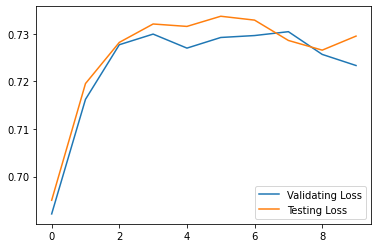

In [14]:
bilstm= run_snli_bilstm()

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Dataset snli downloaded and prepared to /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """


  0%|          | 0/551 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Now epoch 0
0.6760820971347287 0.6788150259594828
Now epoch 1
0.6943710627921155 0.6975465743662832
Now epoch 2
0.6963015647226174 0.6991754046625267
Now epoch 3
0.6959967486283276 0.7063015372085921
Now epoch 4
0.7073765494818126 0.706708744782653
Now epoch 5
0.7124568177199756 0.7074213580372595
Now epoch 6
0.7040235724446251 0.7008042349587702
Now epoch 7
0.7116439748018696 0.7084393769724117
Now epoch 8
0.7089006299532615 0.7037564898707116
Now epoch 9
0.6996545417598049 0.6999898198106485


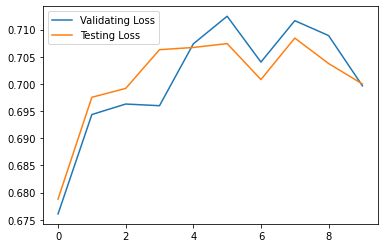

In [13]:
unilstm_gloveless= run_snli_unilstm_gloveless()

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """


  0%|          | 0/551 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Now epoch 0
0.6759804917699654 0.6688384403949913
Now epoch 1
0.6780125990652306 0.6703654687977196
Now epoch 2
0.6934566145092461 0.6944925175608266
Now epoch 3
0.6960983539930908 0.7082357731853812
Now epoch 4
0.6894940052834789 0.6930672910516136
Now epoch 5
0.7021946758788864 0.6996844141301028
Now epoch 6
0.7057508636456005 0.7048763106993791
Now epoch 7
0.6873602926234506 0.6880789982693678
Now epoch 8
0.6996545417598049 0.7020258576809528
Now epoch 9
0.6936598252387726 0.6976483762597985


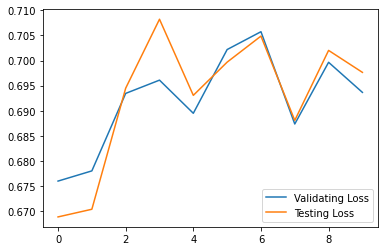

In [14]:
bilstm_gloveless= run_snli_bilstm_gloveless()

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """


  0%|          | 0/551 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Now epoch 0
Current 999 Running Loss: 0.8986346357930451
Current 1999 Running Loss: 0.8516362037372424
Current 2999 Running Loss: 0.8153439955807283
Current 3999 Running Loss: 0.7926391567289128
Current 4999 Running Loss: 0.7776380348707025
Current 5999 Running Loss: 0.7644534993372666
Current 6999 Running Loss: 0.7542030013121976
Current 7999 Running Loss: 0.7445162819072165
Current 8999 Running Loss: 0.7366758480976221
Current 9999 Running Loss: 0.7290804101193464
Current 10999 Running Loss: 0.7219169280616147
Current 11999 Running Loss: 0.7161481056719671
Current 12999 Running Loss: 0.7100441238844657
Current 13999 Running Loss: 0.7049366936962608
Current 14999 Running Loss: 0.7004087719830808
Current 15999 Running Loss: 0.6962917482115528
Current 16999 Running Loss: 0.6923973853555903
0.7483235114814062 0.7465132851471037
Now epoch 1
Current 999 Running Loss: 0.5737178975154703
Current 1999 Running Loss: 0.5763254244512762
Current 2999 Running Loss: 0.575401604457012
Current 3999 R

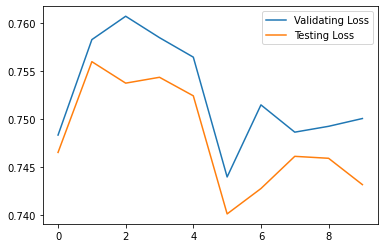

In [24]:
truelstm= run_snli_truelstm()